# Model Accuracy Scoring

<b>Summary:</b><br>
Reads in SmokeyNet, WFABBA GOES-16, WFABBA GOES-17 prediction csv files created by 2_process_wfabba_figlib_join.ipynb. Evaluates the accuracy, precision, recall, and F1 of baseline SmokeyNet, baseline WFABBA GOES-16, baseline WFABBA GOES-17, and the hard vote ensemble model. Then uses the accuracy scores of the baseline models as weights for each individual model for the weighted vote model. Then runs the weighted vote model (a weighted average of each of the baseline model predictions) against accuracy thresholds from 0.2 to 0.7. If weighted average >= threshold, then the weighted vote ensemble model outputs a positive detection prediction<br>

- Get SmokeyNet, WFABBA GOES-16, WFABBA GOES-17 predictions from csv files created by 2_process_wfabba_figlib_join.ipynb.
- Calculate accuracy metrics of baseline SmokeyNet, WFABBA GOES-16, WFABBA GOES-17, and hard voting ensemble model
- Use baseline accuracies of each baseline model for weighted vote model (weighted average calculation)
- Calculate weighted vote model accuracy metrics using various thresholds [0.2, 0.7]


In [27]:
import pandas as pd
import urllib.request
import datetime as dt
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
from haversine import haversine, Unit
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import pytz
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_score
import os
import glob
import matplotlib.pyplot as plt

## 1) Baseline and Hard Vote Ensemble Accuracies

In [28]:
processed_data_dir = "../../data/processed/wfabba"
csv_suffix = "_all_hard_voting_35.csv"
csv_files = glob.glob(os.path.join(processed_data_dir, f"*{csv_suffix}"))
  
master_df = pd.DataFrame()
    
# loop over the list of csv files
for f in csv_files:
    df = pd.read_csv(f)
    df["file"] = f
    master_df = pd.concat([master_df, df])
    
master_df = master_df.reset_index()
master_df = master_df.drop(columns=["index", "Unnamed: 0"])
# master_df

,timestamp,image_gt,image_pred,goes16_pred,goes17_pred,final_pred,type,file
0,2019-08-13 20:41:00+00:00,0.0,0.0,0.0,0.0,0.0,valid,../../data/processed/wfabba\69bravo-e-mobo-c_a...
1,2019-08-13 20:42:00+00:00,0.0,0.0,0.0,0.0,0.0,valid,../../data/processed/wfabba\69bravo-e-mobo-c_a...
2,2019-08-13 20:43:00+00:00,0.0,0.0,0.0,0.0,0.0,valid,../../data/processed/wfabba\69bravo-e-mobo-c_a...
3,2019-08-13 20:44:00+00:00,0.0,0.0,0.0,0.0,0.0,valid,../../data/processed/wfabba\69bravo-e-mobo-c_a...
4,2019-08-13 20:45:00+00:00,0.0,0.0,0.0,0.0,0.0,valid,../../data/processed/wfabba\69bravo-e-mobo-c_a...
...,...,...,...,...,...,...,...,...
10718,2019-09-25 20:50:00+00:00,1.0,1.0,0.0,0.0,0.0,test,../../data/processed/wfabba\wc-s-mobo-c_all_ha...
10719,2019-09-25 20:51:00+00:00,1.0,1.0,0.0,0.0,0.0,test,../../data/processed/wfabba\wc-s-mobo-c_all_ha...
10720,2019-09-25 20:52:00+00:00,1.0,0.0,0.0,0.0,0.0,test,../../data/processed/wfabba\wc-s-mobo-c_all_ha...
10721,2019-09-25 20:53:00+00:00,1.0,0.0,0.0,0.0,0.0,test,../../data/processed/wfabba\wc-s-mobo-c_all_ha...


In [29]:
master_df = master_df.rename(columns={"image_pred":"smokeynet_pred", "final_pred":"majority_vote_pred"})
# master_df

,timestamp,image_gt,smokeynet_pred,goes16_pred,goes17_pred,hard_vote_pred,type,file
0,2019-08-13 20:41:00+00:00,0.0,0.0,0.0,0.0,0.0,valid,../../data/processed/wfabba\69bravo-e-mobo-c_a...
1,2019-08-13 20:42:00+00:00,0.0,0.0,0.0,0.0,0.0,valid,../../data/processed/wfabba\69bravo-e-mobo-c_a...
2,2019-08-13 20:43:00+00:00,0.0,0.0,0.0,0.0,0.0,valid,../../data/processed/wfabba\69bravo-e-mobo-c_a...
3,2019-08-13 20:44:00+00:00,0.0,0.0,0.0,0.0,0.0,valid,../../data/processed/wfabba\69bravo-e-mobo-c_a...
4,2019-08-13 20:45:00+00:00,0.0,0.0,0.0,0.0,0.0,valid,../../data/processed/wfabba\69bravo-e-mobo-c_a...
...,...,...,...,...,...,...,...,...
10718,2019-09-25 20:50:00+00:00,1.0,1.0,0.0,0.0,0.0,test,../../data/processed/wfabba\wc-s-mobo-c_all_ha...
10719,2019-09-25 20:51:00+00:00,1.0,1.0,0.0,0.0,0.0,test,../../data/processed/wfabba\wc-s-mobo-c_all_ha...
10720,2019-09-25 20:52:00+00:00,1.0,0.0,0.0,0.0,0.0,test,../../data/processed/wfabba\wc-s-mobo-c_all_ha...
10721,2019-09-25 20:53:00+00:00,1.0,0.0,0.0,0.0,0.0,test,../../data/processed/wfabba\wc-s-mobo-c_all_ha...


In [30]:
# get only the test data
master_copy_df = master_df[master_df["type"] == "test"].copy()

In [32]:
# Calculate the baseline accuracies of the individual models and the hard vote ensemble
image_labels = master_copy_df[~master_copy_df["image_gt"].isna()]["image_gt"]
smokeynet_preds = master_copy_df[~master_copy_df["image_gt"].isna()]["smokeynet_pred"]
goes16_preds = master_copy_df[~master_copy_df["image_gt"].isna()]["goes16_pred"]
goes17_preds = master_copy_df[~master_copy_df["image_gt"].isna()]["goes17_pred"]
hard_vote_ensemble_preds = master_copy_df[~master_copy_df["image_gt"].isna()]["hard_vote_pred"]

smokeynet_baseline_score = accuracy_score(image_labels, smokeynet_preds)
goes16_baseline_score = accuracy_score(image_labels, goes16_preds)
goes17_baseline_score = accuracy_score(image_labels, goes17_preds)
hard_vote_ensemble_score = accuracy_score(image_labels, hard_vote_ensemble_preds)

print("Baseline score SmokeyNet:", smokeynet_baseline_score)
print("Baseline score GOES-16:", goes16_baseline_score)
print("Baseline score GOES-17:", goes17_baseline_score)
print("Hard Vote Ensemble score:", hard_vote_ensemble_score)

Baseline score SmokeyNet: 0.7832575068243858
Baseline score GOES-16: 0.5179253867151956
Baseline score GOES-17: 0.5666969972702457
Hard Vote Ensemble score: 0.5652411282984532


In [33]:
# smokeynet baseline precision, recall, F1
precision_recall_fscore_support(image_labels, smokeynet_preds, average = 'binary')

(0.8464818763326226, 0.7049005681818182, 0.7692307692307693, None)

In [34]:
# goes16 baseline precision, recall, F1
precision_recall_fscore_support(image_labels, goes16_preds, average = 'binary')

(0.9826589595375722, 0.060369318181818184, 0.11375041820006691, None)

In [35]:
# goes17 baseline precision, recall, F1
precision_recall_fscore_support(image_labels, goes17_preds, average = 'binary')

(0.9559748427672956, 0.16193181818181818, 0.2769511084117826, None)

In [36]:
#hard voting ensemble precision, recall, F1
precision_recall_fscore_support(image_labels, hard_vote_ensemble_preds, average = 'binary')

(0.9908045977011494, 0.15305397727272727, 0.26514918486619504, None)

## 2) Weighted Voting Ensemble Model Accuracies

In [37]:
# weighted average voting

#Voting weights based off of the accuracies of the baseline SmokeyNet, WFABBA GOES-16, & WFABBA GOES-17 models
smokeynet_weight = 0.7797790994052677
goes16_weight = 0.513338997451147
goes17_weight = 0.5634664401019541

master_copy_df["weighted_avg"]  = \
    ((smokeynet_weight * smokeynet_preds) + (goes16_weight * goes16_preds) + (goes17_weight * goes17_preds)) \
    / (smokeynet_weight + goes16_weight + goes17_weight)

# voting threshold 0.2
master_copy_df["thresh2"] = master_copy_df["weighted_avg"] >= 0.2
master_copy_df["thresh2"] = master_copy_df["thresh2"].astype(int)

# voting threshold 0.3
master_copy_df["thresh3"] = master_copy_df["weighted_avg"] >= 0.3
master_copy_df["thresh3"] = master_copy_df["thresh3"].astype(int)

# voting threshold 0.4
master_copy_df["thresh4"] = master_copy_df["weighted_avg"] >= 0.4
master_copy_df["thresh4"] = master_copy_df["thresh4"].astype(int)

# voting threshold 0.5
master_copy_df["thresh5"] = master_copy_df["weighted_avg"] >= 0.5
master_copy_df["thresh5"] = master_copy_df["thresh5"].astype(int)

# voting threshold 0.6
master_copy_df["thresh6"] = master_copy_df["weighted_avg"] >= 0.6
master_copy_df["thresh6"] = master_copy_df["thresh6"].astype(int)

# voting threshold 0.7
master_copy_df["thresh7"] = master_copy_df["weighted_avg"] >= 0.7
master_copy_df["thresh7"] = master_copy_df["thresh7"].astype(int)

master_copy_df

,timestamp,image_gt,smokeynet_pred,goes16_pred,goes17_pred,hard_vote_pred,type,file,weighted_avg,thresh2,thresh3,thresh4,thresh5,thresh6,thresh7
80,2019-06-10 19:44:00+00:00,0.0,0.0,0.0,0.0,0.0,test,../../data/processed/wfabba\bh-w-mobo-c_all_ha...,0.000000,0,0,0,0,0,0
81,2019-06-10 19:45:00+00:00,0.0,0.0,0.0,0.0,0.0,test,../../data/processed/wfabba\bh-w-mobo-c_all_ha...,0.000000,0,0,0,0,0,0
82,2019-06-10 19:46:00+00:00,0.0,0.0,0.0,0.0,0.0,test,../../data/processed/wfabba\bh-w-mobo-c_all_ha...,0.000000,0,0,0,0,0,0
83,2019-06-10 19:47:00+00:00,0.0,0.0,0.0,0.0,0.0,test,../../data/processed/wfabba\bh-w-mobo-c_all_ha...,0.000000,0,0,0,0,0,0
84,2019-06-10 19:48:00+00:00,0.0,0.0,0.0,0.0,0.0,test,../../data/processed/wfabba\bh-w-mobo-c_all_ha...,0.000000,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10718,2019-09-25 20:50:00+00:00,1.0,1.0,0.0,0.0,0.0,test,../../data/processed/wfabba\wc-s-mobo-c_all_ha...,0.420007,1,1,1,0,0,0
10719,2019-09-25 20:51:00+00:00,1.0,1.0,0.0,0.0,0.0,test,../../data/processed/wfabba\wc-s-mobo-c_all_ha...,0.420007,1,1,1,0,0,0
10720,2019-09-25 20:52:00+00:00,1.0,0.0,0.0,0.0,0.0,test,../../data/processed/wfabba\wc-s-mobo-c_all_ha...,0.000000,0,0,0,0,0,0
10721,2019-09-25 20:53:00+00:00,1.0,0.0,0.0,0.0,0.0,test,../../data/processed/wfabba\wc-s-mobo-c_all_ha...,0.000000,0,0,0,0,0,0


### 0.2 voting threshold accuracy, precision, recall, F1

In [38]:
acc_thresh2 = accuracy_score(image_labels, master_copy_df["thresh2"])

In [39]:
p_thresh2, r_thresh2, f_thresh2, s_thresh2 = precision_recall_fscore_support(image_labels, master_copy_df["thresh2"], average = 'binary')

### 0.3 voting threshold accuracy, precision, recall, F1

In [40]:
acc_thresh3 = accuracy_score(image_labels, master_copy_df["thresh3"])

In [41]:
p_thresh3, r_thresh3, f_thresh3, s_thresh3 = precision_recall_fscore_support(image_labels, master_copy_df["thresh3"], average = 'binary')

### 0.4 voting threshold accuracy, precision, recall, F1

In [42]:
acc_thresh4 = accuracy_score(image_labels, master_copy_df["thresh4"])

In [43]:
p_thresh4, r_thresh4, f_thresh4, s_thresh4 = precision_recall_fscore_support(image_labels, master_copy_df["thresh4"], average = 'binary')

### 0.5 voting threshold accuracy, precision, recall, F1

In [44]:
acc_thresh5 = accuracy_score(image_labels, master_copy_df["thresh5"])

In [45]:
p_thresh5, r_thresh5, f_thresh5, s_thresh5 = precision_recall_fscore_support(image_labels, master_copy_df["thresh5"], average = 'binary')

### 0.6 voting threshold accuracy, precision, recall, F1

In [46]:
acc_thresh6 = accuracy_score(image_labels, master_copy_df["thresh6"])

In [47]:
p_thresh6, r_thresh6, f_thresh6, s_thresh6 = precision_recall_fscore_support(image_labels, master_copy_df["thresh6"], average = 'binary')

### 0.7 voting threshold accuracy, precision, recall, F1

In [48]:
acc_thresh7 = accuracy_score(image_labels, master_copy_df["thresh7"])

In [49]:
p_thresh7, r_thresh7, f_thresh7, s_thresh7 = precision_recall_fscore_support(image_labels, master_copy_df["thresh7"], average = 'binary')

### Ploting Accuracy & F1 of Weighted Vote Ensemble with Various Thresholds

In [50]:
thresholds = [0.2,0.3,0.4,0.5,0.6,0.7]
accuracies =  [acc_thresh2, acc_thresh3, acc_thresh4, acc_thresh5, acc_thresh6, acc_thresh7]
f1s = [f_thresh2, f_thresh3, f_thresh4, f_thresh5, f_thresh6, f_thresh7]

In [24]:
accuracies

[0.7909008189262966,
 0.7907188353048226,
 0.7847133757961784,
 0.5623293903548681,
 0.5608735213830756,
 0.5575978161965424]

In [25]:
f1s

[0.7796740172579099,
 0.7794399693133871,
 0.7712241345967897,
 0.2551873645091359,
 0.2503883193538366,
 0.24054982817869416]

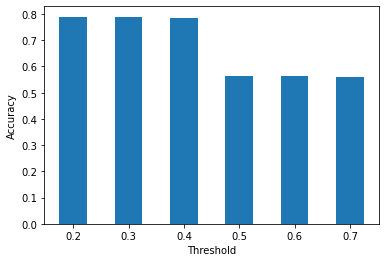

In [54]:
x_range = range(len(thresholds))
plt.bar(x_range, accuracies, width = 0.5)
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.xticks(x_range, thresholds)
plt.show()

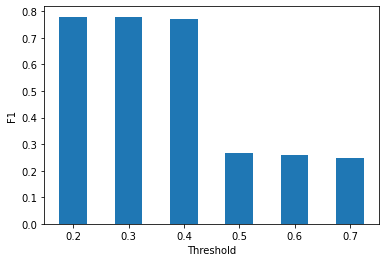

In [55]:
x_range = range(len(thresholds))
plt.bar(x_range, f1s, width = 0.5)
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.xticks(x_range, thresholds)
plt.show()